# Clifford Notebok

## To Do
- Code
    [-] new repo
    [X] make installable
    - unit tests
    [X] conform to style/linting guides
    - streamline notebook
[X] go from symplectic to tableau (i.e., keep phase bits)
- revisit dataset generation
    - remove redundancy
    - consider uniform sampling as opposed to random walk sampling
- get results and add to paper
- consider moving to GPU
    - doesn't speed up - probably because of way data is generated on the fly
- improve LGF training
- implement the genetic algorithm approach
- code up Djikstra if possible
- there seems to be an issue with my parallelization, running n scripts simultaneously results in each of them being slower then they would if I ran them in serial.

In [1]:
import tqdm
import os
import pickle
from collections import Counter
import itertools
import random
import numpy as np
from scipy.sparse import csr_array
import networkx as nx
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import qiskit
from qiskit.quantum_info import random_clifford, Clifford
from qiskit.synthesis import synth_clifford_full
from qiskit import Aer, execute, QuantumCircuit

#sys.path.append("..")
#import qcircuitnlp.utils as utils
import clifford as cl

In [2]:
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from cycler import cycler

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rc('font', family='serif',size=14)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=14)
plt.rcParams['ytick.minor.size'] = 3.0
matplotlib.rcParams.update({"axes.grid" : True, 
                            "grid.alpha": 0.75,
                            "grid.linewidth": 0.5})
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
## if there is a GPU, use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(device)

cpu


In [4]:
## Set RNG
rng = np.random.default_rng(1337)

## Preliminaries

In [ ]:
Clifford(QuantumCircuit(5)).tableau.shape

How does the size of the Clifford group scale with circuit width $n$ (qubits)?

In [ ]:
for n in range(2, 7):
    print(f'n = {n}')
    print(f'  Move set size = {int(cl.size_movet_set(n))}')
    print(f'  Clifford group size = {np.exp(cl.clifford_log_dim(n)):.2e}')

Inspect a random sequence

In [ ]:
cl.random_sequence(rng, 10, 3)

## Data Analysis

Analyze the data generated by running `clifford.py` for various circuit widths.

In [ ]:
## make a figure directory
if not os.path.exists('figures'):
    os.makedirs('figures')

In [ ]:
## print out list of circuit widths for which there is data
data_dirs = [dir for dir in os.listdir('data') if 'data_n' in dir]
num_qubit_list = np.sort([int(dir[7:]) for dir in data_dirs])
for n in num_qubit_list:
    print(f'data file found for n = {n}')

In [ ]:
type(torch.mean(torch.tensor([1.0,1])))

In [ ]:
type(device)

In [ ]:
circuit = QuantumCircuit(3)
circuit.h(1)
circuit.cx(0, 1)
clifford1 = Clifford(circuit)

circuit = QuantumCircuit(3)
clifford2 = Clifford(circuit)
1 * clifford2.tableau

In [ ]:
type(lgf_model)

In [ ]:
clifford1 & clifford2

Examine the loss, both throughout training and the final value.

In [ ]:
## use a different color scheme to plot a large number of curves
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors_tab = cmap.colors  # type: list

fig, ax = plt.subplots(1, 2, figsize=(2*7,5))
[ax[i].set_prop_cycle(color=colors_tab) for i in range(len(ax))]

final_loss_list = []
for num_qubits in num_qubit_list:
    loss_history = np.load(f'data/data_n_{num_qubits}/loss_history.npy')
    ax[0].plot(np.asarray(loss_history), label=f'n={num_qubits}')
    final_loss_list.append(np.mean(loss_history[-10:]))
    
ax[0].set_xlabel('training iterations')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss Throughout Training')
ax[0].legend()#bbox_to_anchor=(-0.2, 1))

ax[1].plot(num_qubit_list, final_loss_list, '--o', markeredgecolor='k')
ax[1].set_xlabel(r'circuit width $n$')
ax[1].set_ylabel('loss')
ax[1].set_title('Final Loss')

plt.minorticks_on()
plt.tight_layout()
plt.savefig('figures/training_history.png')

plt.show()

Show the results for the LGF greedy algorithm.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2*7,5))
#ax[0].set_prop_cycle(color=colors)
#ax[1].set_prop_cycle(color=colors)

for i, num_qubits in enumerate(num_qubit_list):
    
    with open(f'data/data_n_{num_qubits}/steps_until_success.pkl', 'rb') as f:
        steps_until_success = pickle.load(f)

    cum_steps_utils_success_lgf = np.sort([n for n in steps_until_success['lgf'] if n is not None])

    ax[0].step(
        cum_steps_utils_success_lgf, 
        np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf']), 
        label=f'n={num_qubits}',
        linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
        )
    ax[1].step(
        cum_steps_utils_success_lgf, 
        np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf']), 
        label=f'n={num_qubits}',
        linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
        )

ax[0].set_xlabel('Weighted Distance')
ax[0].set_ylabel('Fraction of Instances Solved')
ax[0].legend()
ax[0].set_title('Greedy Algorithm')

ax[1].set_xscale('log')
ax[1].set_xlabel('Weighted Distance')
ax[1].set_ylabel('Fraction of Instances Solved')
ax[1].set_title('Greedy Algorithm (log scale)')

plt.minorticks_on()
plt.tight_layout()

plt.show()

Now add in the comparison with the built-in Qiskit method.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2*7,5))

for i, num_qubits in enumerate(num_qubit_list):
    
    with open(f'data/data_n_{num_qubits}/steps_until_success.pkl', 'rb') as f:
        steps_until_success = pickle.load(f)

    cum_steps_utils_success_lgf = np.sort([n for n in steps_until_success['lgf'] if n is not None])
    #cum_steps_utils_success_random = np.sort([n for n in steps_until_success['random'] if n is not None])
    cum_steps_utils_success_qiskit = np.sort([n for n in steps_until_success['qiskit'] if n is not None])

    ax[0].step(
        cum_steps_utils_success_lgf, 
        np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf']), 
        label=f'n={num_qubits}',
        linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
        )
    ax[1].step(
        cum_steps_utils_success_qiskit, 
        np.arange(len(cum_steps_utils_success_qiskit))/len(steps_until_success['qiskit']), 
        label=f'qiskit n={num_qubits}',
        linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
        )
    
    #ax[2].step(
    #    cum_steps_utils_success_lgf, 
    #    np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf']), 
    #    label=f'lgf n={num_qubits}',
    #    linewidth=2, alpha=1.0, linestyle='--', color=colors[i]
    #    )
    #ax[2].step(
    #    cum_steps_utils_success_qiskit, 
    #    np.arange(len(cum_steps_utils_success_qiskit))/len(steps_until_success['qiskit']), 
    #    label=f'qiskit n={num_qubits}',
    #    linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
    #    )    

ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[2].set_xscale('log')

ax[0].set_xlabel('Weighted Distance')
ax[0].set_ylabel('Fraction of Instances Solved')
ax[0].set_title('Greedy Algorithm')
ax[0].legend()
ax[0].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
ax[0].set_ylim([0,1])

ax[1].set_xlabel('Weighted Distance')
ax[1].set_ylabel('Fraction of Instances Solved')
ax[1].set_title('Qiskit')
ax[1].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
ax[1].set_ylim([0,1])

#ax[2].set_xlabel('Weighted Distance')
#ax[2].set_ylabel('Fraction of Instances Solved')
#ax[2].set_title('Comparison')
#ax[2].set_ylim([0,1])
#ax[2].legend(bbox_to_anchor=(1,1))
plt.minorticks_on()
plt.tight_layout()
plt.savefig('figures/cumulative_plot.png')
plt.show()

In [ ]:
len(num_qubit_list)

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(4*7,2*5), dpi=400)
ax = ax.flatten()

## loop over all circuit widths
for i, num_qubits in enumerate(num_qubit_list):
    
    with open(f'data/data_n_{num_qubits}/steps_until_success.pkl', 'rb') as f:
        steps_until_success = pickle.load(f)

    cum_steps_utils_success_lgf = np.sort([n for n in steps_until_success['lgf'] if n is not None])
    #cum_steps_utils_success_random = np.sort([n for n in steps_until_success['random'] if n is not None])
    cum_steps_utils_success_qiskit = np.sort([n for n in steps_until_success['qiskit'] if n is not None])

    ax[i].step(
        cum_steps_utils_success_qiskit, 
        np.arange(len(cum_steps_utils_success_qiskit))/len(steps_until_success['qiskit']), 
        label=f'Qiskit',
        linewidth=3, alpha=1.0, linestyle='-', color='k'
        )    
    ax[i].step(
        cum_steps_utils_success_lgf, 
        np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf']), 
        label=f'Greedy',
        linewidth=3, alpha=1.0, linestyle='--', color='k'
        )

    ax[i].set_xscale('log')
    ax[i].set_title(f'n = {num_qubits}', fontsize=18)
    #ax.legend()
    #ax.set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
    ax[i].set_ylim([0,1])

    if i == 0:
        ax[i].legend()
    if i > 3:
        ax[i].set_xlabel('Weighted Distance', fontsize=18)
    if i in [0, 4]:
        ax[i].set_ylabel('Fraction of Instances Solved')

plt.minorticks_on()
plt.tight_layout()
plt.savefig('figures/cumulative_plot_comparison.png')
plt.show()

In [ ]:
len(steps_until_success['lgf'])

In [ ]:
ratio_improvement = {n:[] for n in num_qubit_list}
ratio_worsen = {n:[] for n in num_qubit_list}

for n in num_qubit_list:
    
    with open(f'data/data_n_{n}/steps_until_success.pkl', 'rb') as f:
        steps_until_success = pickle.load(f)

    steps_utils_success_lgf = np.asarray([x for x in steps_until_success['lgf'] if x is not None])
    steps_utils_success_qiskit = np.asarray([x for i, x in enumerate(steps_until_success['qiskit']) if steps_until_success['lgf'][i] is not None])

    x = np.mean(steps_utils_success_qiskit > steps_utils_success_lgf)
    print(f'(n={n}): fraction of instances where lgf method beats qiskit: %.4f' %x)

    x = np.mean(steps_utils_success_qiskit >= steps_utils_success_lgf)
    print(f'(n={n}): fraction of instances where lgf method beats or matches qiskit: %.4f\n' %x)
    
    for i in range(len(steps_until_success['lgf'])):
        if steps_until_success['lgf'][i] is not None:
            if steps_until_success['lgf'][i] < steps_until_success['qiskit'][i]:
                ratio = - (steps_until_success['lgf'][i] - steps_until_success['qiskit'][i]) / steps_until_success['qiskit'][i]
                ratio_improvement[n].append(ratio)
            elif steps_until_success['lgf'][i] > steps_until_success['qiskit'][i]:
                ratio = (steps_until_success['lgf'][i] - steps_until_success['qiskit'][i]) / steps_until_success['qiskit'][i]
                ratio_worsen[n].append(ratio)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2*7,5))

for i, n in enumerate(num_qubit_list):
    ax[0].hist(
        ratio_improvement[n],
        50,
        label=f'n={n}', 
        density=True, 
        alpha=1, 
        histtype='step', 
        linewidth=3, color=colors[i]
        )
    ax[0].legend()
    ax[0].set_title('Fractional Improvement Us vs Qiskit')

    ax[1].hist(
        ratio_worsen[n], 
        20,
        label=f'n={n}', 
        density=True, 
        alpha=1, 
        histtype='step', 
        linewidth=3,
        color=colors[i]
        )
    ax[1].legend()
    ax[1].set_title('Fractional Improvement Qiskit vs Us')
    #ax[1].set_xlim([0,200])
    
plt.show()

In [ ]:
ratio_improvement[6][0:10]

In [ ]:
ratio_worsen[6][0:10]

Analyze the effect of the random seeds on the success/probability of the hillclimbing algorithm.

In [ ]:
from importlib import reload
reload(cl)

In [ ]:
num_qubits = 4
data_dir = f'data/data_n_{num_qubits}/'

lgf_model = cl.LGFModel(
    num_qubits = num_qubits,
    device = device,
    rng = rng,
    drop_phase_bit = True,
    hidden_layers = [32, 16, 4]
    )

checkpoint = torch.load(data_dir + 'checkpoint')
lgf_model.load_state_dict(checkpoint)

In [ ]:
with open(data_dir + 'args.pkl', 'rb') as f:
    x = pickle.load(f)
x

In [ ]:
max_iter = 1000
num_initial_state_trials = 100
num_hillclimb_trials = 100
success_matrix = np.zeros( (num_initial_state_trials, num_hillclimb_trials))

## loop over initial states
for initial_seed in range(num_initial_state_trials):

    problem = cl.Problem(lgf_model.num_qubits, seed=initial_seed)
    success_count = 0.0

    ## loop over hillclimbing seeds
    pbar = tqdm.trange(num_hillclimb_trials)
    for hillclimbing_seed in pbar:

        result = cl.hillclimbing(
            problem.state,
            lgf_model,
            max_iter=max_iter,
            seed=hillclimbing_seed,
            )

        success_matrix[initial_seed, hillclimbing_seed] = result['success'] * 1.0
        success_count += result['success'] * 1.0
        pbar.set_description("success rate=%.4f" % (success_count / (hillclimbing_seed + 1)))

In [ ]:
## average over initial state seeds
## each entry is a different hillclimbing seed
np.mean(success_matrix, axis=0)

In [ ]:
## average over hillclimbing seeds
## each entry is a different initial seed
np.mean(success_matrix, axis=1)

## Learned Guidance Function

Generate a dataset for the LGF by randomly sampling sequences of Cliffords and then converting to tableaus. Each data point will be of the form $(x, \ell)$, with $x$ the tableau and $\ell$ the length of the sequence. 
- I am applying the Qiskit synthesis approach which might find a smaller $\ell$ in some cases.
- For the model, we want f(tableau) -> positive integer
    - might want to use an f that takes into account the fact that the tableau is a symplectic matrix, or at least binary, for now can just use a feed-forward NN
    - also should think about how to enforce the condition that the output is a positive integer. For now, actually any real number will do, so let's just use a single real-valued output. Poisson regression?

- Do I want to use the synthesis as a shortcut?
- What's the best NN parameterization?
- What's up with the oscillatons in the training loss curve?
- consider different data generation techniques

In [5]:
## check that both ways of updating the state are consistent
## (1: applying move using built-in qiskit method, 2: matrix multiplication in numpy)

problem = cl.Problem(5)

arr1 = []
for i in range(len(problem.move_set)):
    arr1.append(1*problem.apply_move(problem.move_set[i]).tableau)
arr1 = np.asarray(arr1)

arr2 = np.einsum(
    'ij, mjk -> mik',
    1*problem.state.tableau,
    problem.move_set_array
    ) % 2

np.array_equal(arr1, arr2)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (10,11)->(10,newaxis,11) (60,10,11)->(60,newaxis,11,10) 

In [9]:
from importlib import reload
reload(cl)

<module 'clifford' from "/Users/gavinhartnett/Documents/GitHub/Rubik's Cube/rubiks-clifford-synthesis/clifford.py">

In [10]:
#import cProfile
#reload(utils)
#cProfile.run("lgf_model.train(batch_size=1000, lr=1e-3, n_epochs=3, weight_dict=weight_dict)")

#cProfile.run(
#   "cl.hillclimbing(cl.Problem(num_qubits, seed=3).state, lgf_model, max_iter=10, seed=3, random=False)",
#    sort='cumtime'
#   )

In [11]:
def relative_weight_x_to_cx(fidelity_x, fidelity_cx):
    '''
    How many x gates are equivalent to a single cx gate, 
    in terms of fidelity reduction?
    '''
    return np.log(fidelity_cx) / np.log(fidelity_x)

relative_weight_x_to_cx(1 - 2.556e-4, 1 - 9.263e-3)

36.40445614783131

In [12]:
weight_dict = {
    'x':1,
    'y':1,
    'z':1,
    'h':1,
    's':1,
    'sdg':1,
    'cx':30,
    'swap':90
    }
#cl.normalize_dict(weight_dict)
weight_dict

{'x': 1, 'y': 1, 'z': 1, 'h': 1, 's': 1, 'sdg': 1, 'cx': 30, 'swap': 90}

In [21]:
reload(cl)

num_qubits = 4
drop_phase_bit = False

x, seq_lens = cl.generate_data_batch(
    rng,
    13,
    num_qubits,
    device,
    weight_dict,
    high=40,
    drop_phase_bit=drop_phase_bit
    )

lgf_model = cl.LGFModel(
    num_qubits=num_qubits,
    device=device,
    rng=rng,
    hidden_layers=[32, 16, 4],
    drop_phase_bit=drop_phase_bit
    ).to(device)

In [22]:
lgf_model.forward(x)

tensor([0.7071, 0.7077, 0.7079, 0.7095, 0.7071, 0.7039, 0.7088, 0.7072, 0.7070,
        0.7071, 0.7092, 0.7069, 0.7088], grad_fn=<SqueezeBackward0>)

In [23]:
seq_lens

tensor([4.2222, 0.2540, 5.9444, 2.7381, 3.1825, 4.9603, 0.2381, 0.6667, 5.6825,
        3.9524, 3.0476, 1.1905, 1.9841])

In [24]:
loss_history = lgf_model.train(
    batch_size=2000,
    lr=1e-5,
    num_epochs=10,
    weight_dict=weight_dict,
    #high=50
    high = int(50*np.log(num_qubits)/np.log(2))
    )

loss=0.2972: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


In [25]:
x, seq_lens = cl.generate_data_batch(
    rng,
    13,
    num_qubits,
    device,
    weight_dict,
    high=100,
    drop_phase_bit=drop_phase_bit
    )

lgf_model.forward(x), seq_lens

(tensor([0.7078, 0.7058, 0.7065, 0.7055, 0.7073, 0.7097, 0.7083, 0.7069, 0.7083,
         0.7078, 0.7072, 0.7062, 0.7083], grad_fn=<SqueezeBackward0>),
 tensor([ 8.0476,  6.9762,  8.8413, 12.4286,  8.8016,  6.9444,  1.6905,  5.0238,
          6.6508,  0.7302,  3.8810, 11.5556, 13.1508]))

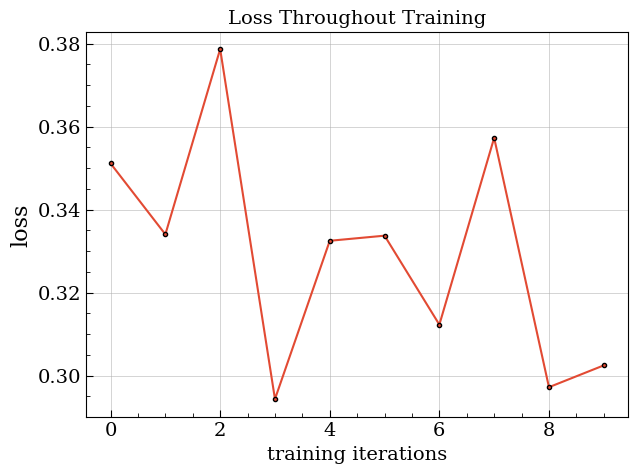

In [26]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(np.asarray(loss_history), '-o', markersize=3, markeredgecolor='k')
ax.set_xlabel('training iterations')
ax.set_ylabel('loss', fontsize=16)
ax.set_title('Loss Throughout Training', fontsize=14)
#ax.set_ylim([0, 50])
plt.minorticks_on()
#ax.set_xscale('log')
plt.show()

In [27]:
reload(cl)

num_trials = 10
max_iter = 10

## using the LGF
steps_until_success = cl.compute_weighted_steps_until_success(
    lgf_model=lgf_model,
    weight_dict=weight_dict,
    num_trials=num_trials, 
    max_iter=max_iter
    )

100%|██████████| 10/10 [00:00<00:00, 15.27it/s]


In [28]:
## applying a purely random move
steps_until_success_random = cl.compute_weighted_steps_until_success(
    lgf_model=lgf_model, 
    weight_dict=weight_dict,
    num_trials=num_trials, 
    max_iter=max_iter,
    method='random'
    )

100%|██████████| 10/10 [00:00<00:00, 131.38it/s]


In [29]:
## use qiskit method
steps_until_success_qiskit = cl.compute_weighted_steps_until_success(
    lgf_model=lgf_model, 
    weight_dict=weight_dict,
    num_trials=num_trials, 
    max_iter=max_iter,
    method='qiskit'
    )

100%|██████████| 10/10 [00:00<00:00, 117.11it/s]


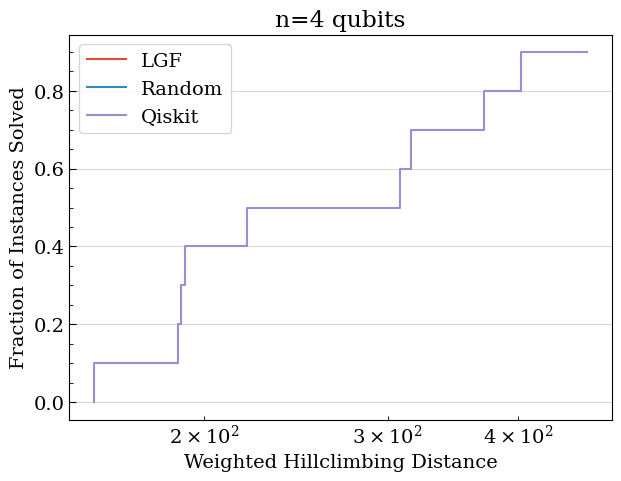

In [30]:
cum_steps_utils_success = np.sort([n for n in steps_until_success if n is not None])
cum_steps_utils_success_random = np.sort([n for n in steps_until_success_random if n is not None])
cum_steps_utils_success_qiskit = np.sort(steps_until_success_qiskit)

fig, ax = plt.subplots(figsize=(7,5))
ax.step(
    cum_steps_utils_success, 
    np.arange(len(cum_steps_utils_success))/len(steps_until_success), 
    label='LGF'
    )
ax.step(
    cum_steps_utils_success_random, 
    np.arange(len(cum_steps_utils_success_random))/len(steps_until_success_random), 
    label='Random'
    )
ax.step(
    cum_steps_utils_success_qiskit, 
    np.arange(len(cum_steps_utils_success_qiskit))/len(steps_until_success_qiskit), 
    label='Qiskit'
    )
ax.set_xscale('log')
ax.set_xlabel('Weighted Hillclimbing Distance')
ax.set_ylabel('Fraction of Instances Solved')
ax.set_title(f'n={lgf_model.num_qubits} qubits')
plt.legend()
plt.minorticks_on()
plt.show()

In [31]:
Ntrials = 1000
distance = {'qiskit':[], 'lgf':[]}
k = 0

for n in tqdm.trange(Ntrials):

    while True:
        #x = random_clifford(num_qubits, seed=k)
        x = cl.Problem(num_qubits, seed=k).state
        result = cl.hillclimbing(
            x,
            lgf_model,
            max_iter=1000,
            seed=k
            )
        k += 1
        if result['success']:
            #print('success, k=%i' %k)
            break

    distance['qiskit'].append(
        cl.weighted_distance_to_identity(
        synth_clifford_full(x), 
        weight_dict)
        )
    distance['lgf'].append(
        cl.weighted_distance_to_identity(
        result['move_history'], 
        weight_dict)
        )

 26%|██▋       | 264/1000 [10:16:51<28:39:43, 140.19s/it]


KeyboardInterrupt: 

In [59]:
def tableau_composition():
    '''
    check that two arbitrary tableaus can be composed via
    matrix multiplication of the symplectic matrices
    '''
    tableau1 = cl.Problem(5, seed=0).state
    tableau2 = cl.Problem(5, seed=10).state

    term1 = 1*(tableau1 @ tableau2).tableau[:,:-1]

    term2 = np.dot(1*tableau2.tableau[:,:-1], 1*tableau1.tableau[:,:-1])
    term2 = term2 % 2

    assert np.array_equal(term1, term2)

tableau_composition()

In [66]:
x1 = random_clifford(2)
x2 = random_clifford(2)
x12 = x1 @ x2

print('x1 = \n', 1*x1.tableau)
print('x2 = \n', 1*x2.tableau)
print('x1 x2 = \n', 1*x12.tableau)

x1 = 
 [[1 1 0 0 1]
 [0 0 1 1 0]
 [0 0 0 1 1]
 [1 0 1 1 1]]
x2 = 
 [[0 1 1 0 1]
 [1 0 1 1 0]
 [1 0 1 0 0]
 [0 1 0 0 0]]
x1 x2 = 
 [[0 0 1 0 0]
 [0 1 1 0 0]
 [1 1 0 1 0]
 [0 0 1 1 0]]


In [72]:
np.dot(1*x2.tableau[:,:-1], 1*x1.tableau[:,:-1]) % 2, 1*x12.tableau[:,:-1]

(array([[0, 0, 1, 0],
        [0, 1, 1, 0],
        [1, 1, 0, 1],
        [0, 0, 1, 1]]),
 array([[0, 0, 1, 0],
        [0, 1, 1, 0],
        [1, 1, 0, 1],
        [0, 0, 1, 1]]))

In [74]:
np.dot(1*x2.tableau[:,:-1], 1*x1.tableau[:,:-1])

array([[0, 0, 1, 2],
       [2, 1, 1, 2],
       [1, 1, 0, 1],
       [0, 0, 1, 1]])

In [82]:
r1 = 1*x1.tableau[:,-1]
r2 = 1*x2.tableau[:,-1]
r12 = 1*x12.tableau[:,-1]

r1, r2, r12

(array([1, 0, 1, 1]), array([1, 0, 0, 0]), array([0, 0, 0, 0]))

In [94]:
problem = cl.Problem(num_qubits=3)
1 * problem.move_set_tableau[(0, 2, 'cx')].tableau

array([[1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0]])

In [102]:
1 * problem.move_set_tableau[(1, 'h')].tableau[:,:-1] - np.eye(6)

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [96]:
np.transpose(1 * problem.move_set_tableau[(0, 2, 'cx')].tableau[:,:-1]) - 1 * problem.move_set_tableau[(0, 2, 'cx')].tableau[:,:-1]

array([[ 0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0]])

In [99]:
mat = np.asarray([[1, 2, 3,],
                  [4, 5, 6],
                  [7, 8, 9]])

v1 = np.asarray([1, 0, 0])
v2 = np.asarray([0, 1, 0])
v3 = np.asarray([0, 0, 1])

np.dot(mat, v2)

array([2, 5, 8])

In [87]:
r1 + r2

array([2, 0, 1, 1])

In [ ]:
r1

In [84]:
symplectic = np.asarray([[0, 0, 1, 0],
                         [0, 0, 0, 1],
                         [-1, 0, 0, 0], 
                         [0, -1, 0, 0]])

In [86]:
## column vector
np.sum( np.dot(1*x2.tableau[:,:-1], np.dot(symplectic, 1*x1.tableau[:,:-1])), axis=1) % 2

array([1, 1, 1, 1])

In [79]:
1*x12.tableau

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0]])

In [69]:
circ = QuantumCircuit(2)
circ.s(0)
1*Clifford(circ).tableau

array([[1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In [70]:
circ = QuantumCircuit(2)
circ.cx(0, 1)
1*Clifford(circ).tableau

array([[1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0]])

In [71]:
circ = QuantumCircuit(2)
circ.h(0)
1*Clifford(circ).tableau

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [ ]:
x = np.mean([distance['qiskit'][i] > distance['lgf'][i] for i in range(len(distance['qiskit']))])
print('fraction of instances where lgf method beat matches qiskit: %.4f' %x)

x = np.mean([distance['qiskit'][i] >= distance['lgf'][i] for i in range(len(distance['qiskit']))])
print('fraction of instances where lgf method beats or matches qiskit: %.4f' %x)